In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
from wassa.dataset_generation import sm_generative_model, generate_dataset
from wassa.wassa_plots import plot_SM, plot_colored_raster
from wassa.wassa_utils import performance_as_a_function_of_noise

In [3]:
date = '2024-01-24'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
device = 'cuda:1'

## Generative model

In [5]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 255 # number of timesteps for the raster plot (in ms)
    N_samples = 60 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 1 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 16*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = 0 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

../synthetic_data/synthetic_rp_trainset_30_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666.pt
../synthetic_data/synthetic_rp_testset_30_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666.pt


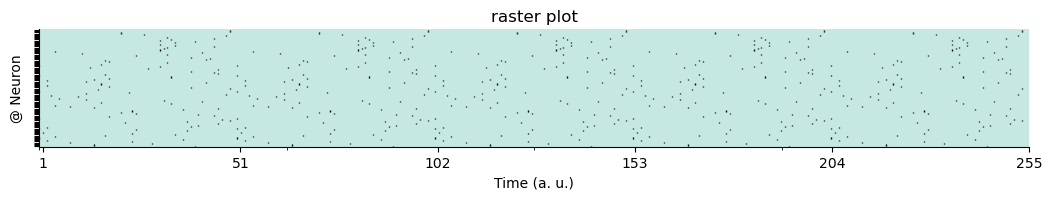

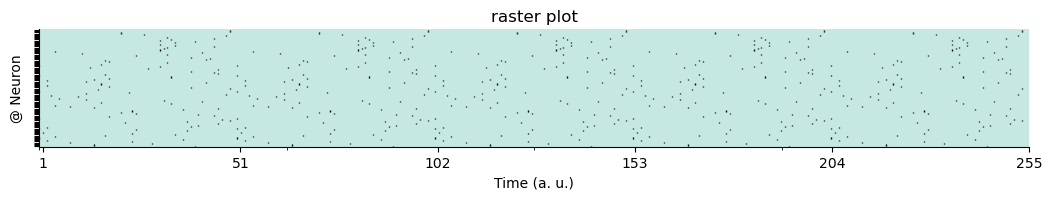

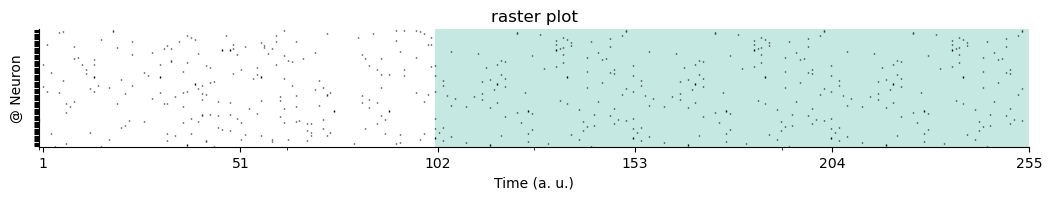

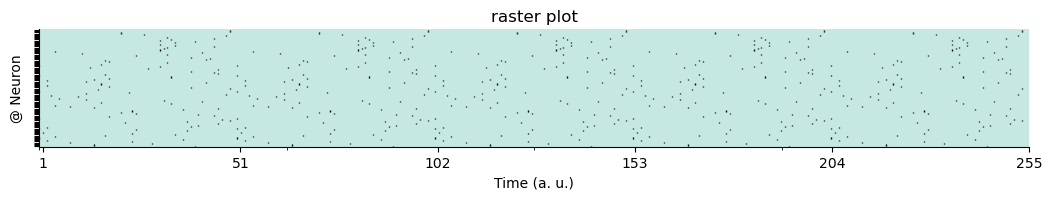

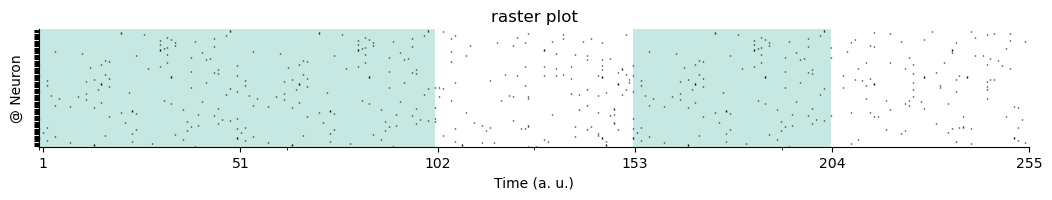

In [6]:
sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, device=device)
for i in range(min(5,trainset_input.shape[0])):
    fig_raster, ax_raster = plot_colored_raster(trainset_input, trainset_output.cpu().numpy(), dataset_parameters.N_delays, indice_trial=i);

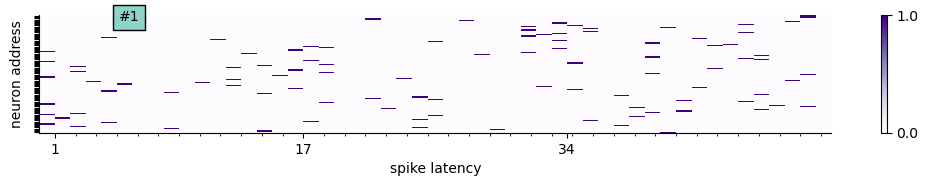

In [7]:
sm = sm_generative_model(dataset_parameters, device = device)
plot_SM(sm.SMs);

In [8]:
class training_parameters():
    kernel_size = (sm.opt.N_SMs, sm.opt.N_pre, sm.opt.N_delays)
    loss_type = 'emd'
    N_learnsteps = 1000
    learning_rate = .001
    penalty_type = None
    smoothwind = 20
    lambda_ = .01
    batch_size = None
    output = 'linear' 
    do_bias = True 
    zeros = 'ignore'
    wass_order = 1
    weight_init = 'flat'
    if not penalty_type: 
        lambda_ = 0
    elif penalty_type[:8] != 'smoothed':
        smoothwind = 0
    if lambda_ == 0:
        penalty_type = None
    def get_parameters(self):
        name = f'{self.loss_type}_{self.output}_{self.penalty_type}_{self.do_bias}_{self.kernel_size}_{self.N_learnsteps}_{self.learning_rate}_{self.lambda_}_{self.batch_size}_{self.smoothwind}'
        if self.loss_type == 'emd':
            name += f'_{self.zeros}_{self.wass_order}'
        return name

In [9]:
params_emd = training_parameters()
params_mse = training_parameters()
params_mse.loss_type = 'mse'

## Robustness to temporal jitter

In [10]:
N_iter = 20
seeds = torch.arange(N_iter)

In [11]:
noise_type = 'jitter'
coefficients = torch.arange(.1,12,1)
results_jitter, coefficients_jitter = performance_as_a_function_of_noise(dataset_parameters, params_emd, params_mse, date, coefficients, noise_type, N_iter = N_iter, seeds = seeds, device=device)

../results/2024-01-24_performance_as_a_function_of_jitter_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_0.10000000149011612_11.100000381469727


## Robustness to additive noise

In [12]:
noise_type = 'additive'
coefficients = torch.arange(0,1,.1)
results_additive, coefficients_additive = performance_as_a_function_of_noise(dataset_parameters, params_emd, params_mse, date, coefficients, noise_type = noise_type, N_iter = N_iter, seeds = seeds, device=device)

../results/2024-01-24_performance_as_a_function_of_additive_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_0.0_0.8999999761581421


## Robustness to neurons' dropout

In [13]:
noise_type = 'dropout'
coefficients = torch.arange(0,1,.1)
results_dropout, coefficients_dropout = performance_as_a_function_of_noise(dataset_parameters, params_emd, params_mse, date, coefficients, noise_type = noise_type, N_iter = N_iter, seeds = seeds, device=device)

../results/2024-01-24_performance_as_a_function_of_dropout_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_0.0_0.8999999761581421


## Figures

In [20]:
seqnmf_results_dropout.shape

torch.Size([4, 20, 10, 3])

In [19]:
results_dropout[2] = 

torch.Size([3, 20, 10, 3])

In [26]:
file_name = '../results/2024_01_24_performance_as_a_function_of_jitter_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_0.10000000149011612_19.100000381469727_seqnmf'
results_jitter, coefficients_jitter = torch.load(file_name, map_location='cpu')

file_name = '../results/2024_01_24_performance_as_a_function_of_additive_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_666_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_0.0_0.8999999761581421_seqnmf'
results_additive, seqnmf_coefficients_additive = torch.load(file_name, map_location='cpu')

file_name = '../results/2024_01_24_performance_as_a_function_of_dropout_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0_1_19_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_0.0_0.8999999761581421_seqnmf'
results_dropout, seqnmf_coefficients_dropout = torch.load(file_name, map_location='cpu')

In [27]:
name_metrics = ['factors similarity', 'kernels similarity', 'mean timings\nsimilarity']
name_methods = ['MSE', 'EMD', 'combined', 'seqNMF']
colors = ['darkolivegreen','blue','purple','orangered']
xlabels = ['std of temporal jitter\n(in a.u.)', 'additive noise (in %)', 'dropout probability']

In [28]:
def plot_results_std(ax, results, coefs, xlabel, ylabel, legend, color, ymax=None, ymin=None, do_legend=False, logplot=False, quantile=False):
     
    mean_, std_ = results.mean(axis=0), results.std(axis=0)
    
    if quantile: 
        q5 = results.quantile(.05,axis=0)
        q95 = results.quantile(.95,axis=0)

    if quantile:
        bottom_ = q5
    elif ymin is not None:
        bottom_ = np.maximum(mean_ - std_, ymin*np.ones([len(mean_)]))
    else:
        bottom_ = mean_ - std_
        
    if quantile:
        top_ = q95
    elif ymax is not None:
        top_= np.minimum(mean_ + std_, ymax*np.ones([len(mean_)]))
    else:
        top_ = mean_ + std_

    if logplot:
        ax.semilogx(coefs, mean_, '.',color=color, label=legend)
    else:
        ax.plot(coefs, mean_, 'P',color=color, markeredgecolor='white', markersize=10, label=legend)

    ax.scatter(coefs.unsqueeze(0).repeat(results.shape[0],1),results, color=color,alpha=.1)

    ax.fill_between(coefs, bottom_, top_, facecolor=color, edgecolor=None, alpha=.3)

    ax.set_ylim(ymin,ymax)
    
    if xlabel: 
        ax.set_xlabel(xlabel, fontsize=14)
    else: 
        ax.set_xticks([])
    if ylabel: 
        ax.set_ylabel(ylabel, fontsize=14)
    else: 
        ax.set_yticks([])
    if do_legend: 
        ax.legend(fontsize=12);

    return ax

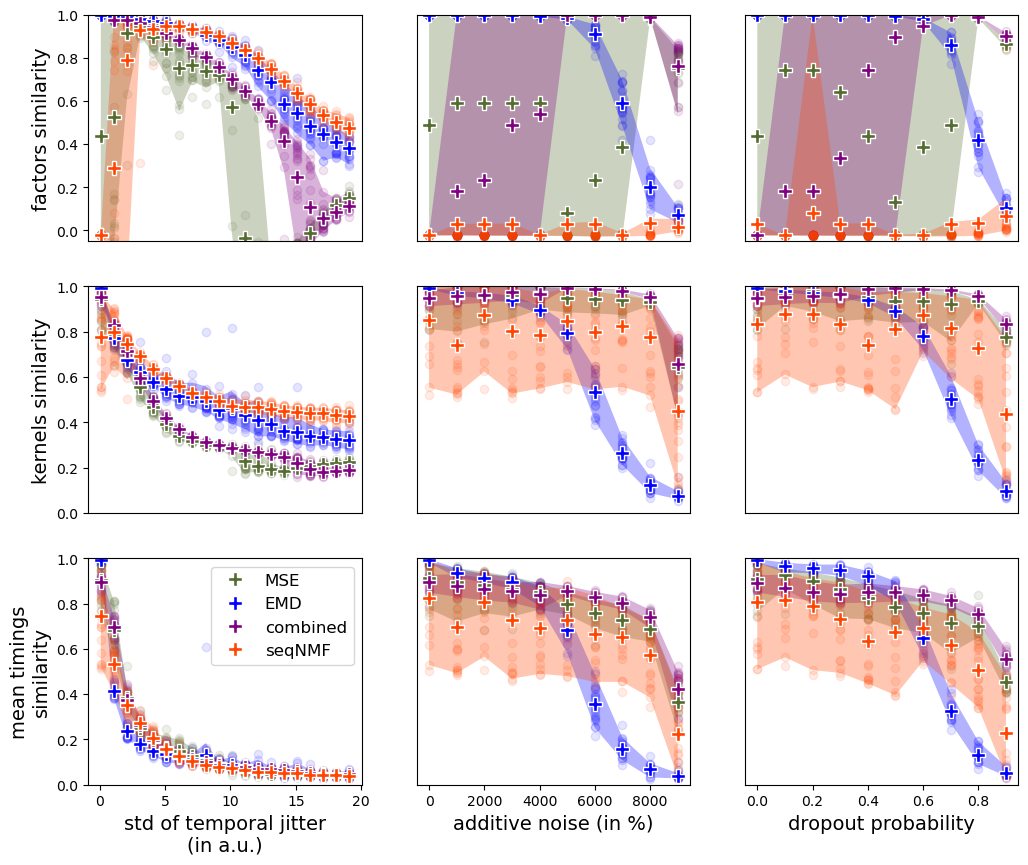

In [29]:
import matplotlib.pyplot as plt

results_all = [[results_jitter, coefficients_jitter], [results_additive, coefficients_additive], [results_dropout, coefficients_dropout]]
fig, ax = plt.subplots(3,3, figsize = (12,10))
for ind_n, noise in enumerate(xlabels):
    results, coef = results_all[ind_n]
    #if ind_n==0:
    #    results, coef = results[:,:,:7,:], coef[:7]
    if ind_n==1: coef *= 100
    for ind_m, measure in enumerate(name_metrics):
        for ind_l, loss in enumerate(name_methods):
            if ind_m!=2: 
                xlabel = None
            else:
                xlabel = noise
            if ind_n==0:
                ylabel = measure
            else:
                ylabel = None
            if ind_m == 0:
                ymax, ymin = 1,-.05
            else:
                ymax,ymin = 1,0
            if ind_m==2 and ind_n==0:
                do_legend = True
            else:
                do_legend = False
            ax[ind_m,ind_n] = plot_results_std(ax[ind_m,ind_n],results[ind_l,:,:,ind_m],coef,xlabel,ylabel,loss,colors[ind_l],do_legend=do_legend,ymax=ymax,ymin=ymin,quantile=True)